In [1]:
import tensorflow as tf
import os
import numpy as np
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
def parse_xml(xml_file, original_size, target_size=(640, 640)):
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
    except ET.ParseError as e:
        print(f"Error parsing XML: {e}")
        return []

    bboxes = []
    width_ratio = target_size[0] / original_size[0]
    height_ratio = target_size[1] / original_size[1]
    
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)  # Convert to float first
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)
        
        # Resize bounding box coordinates
        xmin_resized = int(np.round(xmin * width_ratio))
        ymin_resized = int(np.round(ymin * height_ratio))
        xmax_resized = int(np.round(xmax * width_ratio))
        ymax_resized = int(np.round(ymax * height_ratio))
        
        bboxes.append([xmin_resized, ymin_resized, xmax_resized, ymax_resized])
    
    return bboxes

def load_image(image_path, target_size=(640, 640)):
    image = Image.open(image_path)
    image = image.resize(target_size)  # Resize image to target size
    return np.array(image)

def load_data(image_dir, annotation_dir, target_size=(640, 640)):
    images = []
    bboxes_all = []
    
    for image_file in os.listdir(image_dir):
        if image_file.endswith('.jpg'):
            image_path = os.path.join(image_dir, image_file)
            annotation_path = os.path.join(annotation_dir, image_file.replace('.jpg', '.xml'))
            
            image_resized = load_image(image_path, target_size)
            original_size = Image.open(image_path).size  # Get original size before resizing
            
            boxes = parse_xml(annotation_path, original_size, target_size)
            
            if boxes:
                images.append(image_resized)
                bboxes_all.append(np.array(boxes, dtype=np.int32))  # Convert to numpy array of dtype=int32
    
  
    images = np.array(images)
    

    max_boxes = max(len(boxes) for boxes in bboxes_all)
    bboxes_array = np.zeros((len(bboxes_all), max_boxes, 4), dtype=np.int32)
    
    for i, boxes in enumerate(bboxes_all):
        bboxes_array[i, :len(boxes)] = boxes
    
    return images, bboxes_array


train_images, train_bboxes = load_data('Tensorflow/workspace/images/train/images', 'Tensorflow/workspace/images/train/annotations')
# val_images, val_bboxes = load_data('dataset/valid/images', 'dataset/valid/annotation')
# test_images, test_bboxes = load_data('dataset/test/images', 'dataset/test/annotation')


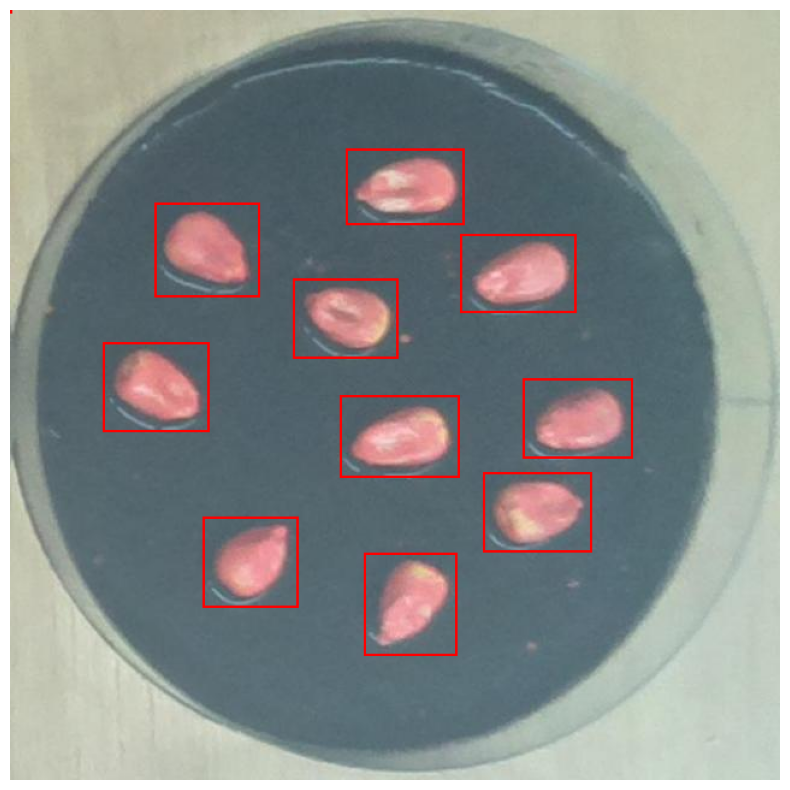

In [8]:
def plot_image_with_bboxes(image, bboxes):
    image_pil = Image.fromarray(image)
    draw = ImageDraw.Draw(image_pil)
    
    for bbox in bboxes:
        draw.rectangle([bbox[0], bbox[1], bbox[2], bbox[3]], outline="red", width=2)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image_pil)
    plt.axis('off')
    plt.show()
    
plot_image_with_bboxes(train_images[34], train_bboxes[34])


In [10]:
print(train_bboxes[34])

[[279 115 377 178]
 [120 160 207 238]
 [235 223 322 289]
 [374 186 470 251]
 [ 77 276 165 350]
 [274 320 373 388]
 [426 306 517 372]
 [393 384 483 450]
 [160 421 239 496]
 [294 451 371 536]
 [  0   0   0   0]]


In [ ]:
# Print the shapes of the data
print("Shape of train_images:", test_images.shape)
print("Shape of train_bboxes:", test_bboxes.shape)

# Verify the content of train_bboxes
print("First entry of train_bboxes:", train_bboxes[0])

# Normalize bounding boxes
height, width, _ = train_images[0].shape
train_bboxes_normalized = train_bboxes / [width, height, width, height]
train_bboxes_flattened = train_bboxes_normalized.reshape((train_bboxes_normalized.shape[0], -1))

# Print the shape after flattening
print("Shape of train_bboxes_flattened:", train_bboxes_flattened.shape)
print("First entry of train_bboxes_flattened:", train_bboxes_flattened[0])


In [14]:
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

def augment_image(image, bboxes):
    # Define augmentation pipeline
    seq = iaa.Sequential([
        iaa.Resize((640, 640)),
        iaa.Multiply((0.2, 0.8)),  
        iaa.Fliplr(0.5),  
        iaa.Flipud(0.5), 
        iaa.Affine(rotate=(90)),  
        #iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),  # Translation
        iaa.Affine(scale=(0.8, 1.2))
    ])
    
    # Convert bounding boxes to imgaug format
    bbs = BoundingBoxesOnImage([BoundingBox(x1=bb[0], y1=bb[1], x2=bb[2], y2=bb[3]) for bb in bboxes], shape=image.shape)
    
    # Apply augmentation
    image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
    
    # Clip bounding boxes to image dimensions
    bbs_aug = bbs_aug.remove_out_of_image().clip_out_of_image()
    
    # Convert bounding boxes back to numpy array
    bboxes_aug = np.array([[bb.x1, bb.y1, bb.x2, bb.y2] for bb in bbs_aug])
    
    return image_aug, bboxes_aug


augmented_image, augmented_bboxes = augment_image(train_images[34], train_bboxes[34])


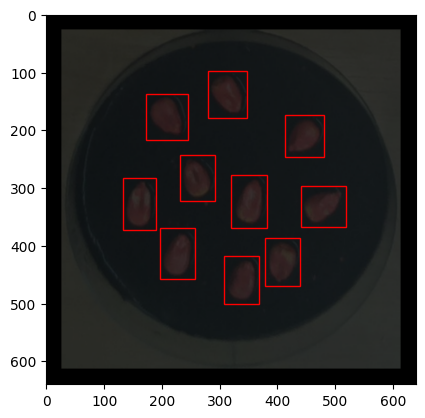

In [15]:
def plot_image_with_bboxes(image, bboxes):
    plt.imshow(image)
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, edgecolor='red', facecolor='none'))
    plt.show()

plot_image_with_bboxes(augmented_image, augmented_bboxes)


In [221]:
import os
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import numpy as np
import cv2
import xml.etree.ElementTree as ET

# Define the augmentation function
def augment_image(image, bboxes):
    # Define augmentation pipeline
    seq = iaa.Sequential([
        iaa.Resize((640, 640)),
        iaa.Multiply((0.2, 0.6)),  # Brightness adjustment
        iaa.Fliplr(0.5),  # Horizontal flip
        iaa.Flipud(0.5),  # Vertical flip
        iaa.Affine(rotate=(90)),  # Rotation
        iaa.Affine(scale=(0.8, 1.2))  # Zoom
    ])
    
    # Convert bounding boxes to imgaug format
    bbs = BoundingBoxesOnImage([BoundingBox(x1=bb[0], y1=bb[1], x2=bb[2], y2=bb[3]) for bb in bboxes], shape=image.shape)
    
    # Apply augmentation
    image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
    
    # Clip bounding boxes to image dimensions
    bbs_aug = bbs_aug.remove_out_of_image().clip_out_of_image()
    
    # Convert bounding boxes back to numpy array
    bboxes_aug = np.array([[bb.x1, bb.y1, bb.x2, bb.y2] for bb in bbs_aug])
    
    return image_aug, bboxes_aug




In [222]:
# Function to save bounding boxes in XML format (Pascal VOC format)
def save_bboxes_to_xml(image_path, bboxes, output_path):
    annotation = ET.Element('annotation')
    ET.SubElement(annotation, 'folder').text = os.path.basename(os.path.dirname(image_path))
    ET.SubElement(annotation, 'filename').text = os.path.basename(image_path)
    size = ET.SubElement(annotation, 'size')
    ET.SubElement(size, 'width').text = str(640)
    ET.SubElement(size, 'height').text = str(640)
    ET.SubElement(size, 'depth').text = str(3)

    for bbox in bboxes:
        obj = ET.SubElement(annotation, 'object')
        ET.SubElement(obj, 'name').text = 'Zea mays'
        bndbox = ET.SubElement(obj, 'bndbox')
        ET.SubElement(bndbox, 'xmin').text = str(int(bbox[0]))
        ET.SubElement(bndbox, 'ymin').text = str(int(bbox[1]))
        ET.SubElement(bndbox, 'xmax').text = str(int(bbox[2]))
        ET.SubElement(bndbox, 'ymax').text = str(int(bbox[3]))

    tree = ET.ElementTree(annotation)
    tree.write(output_path)

# Directory to save augmented images and bounding boxes
output_image_dir = "Tensorflow/workspace/images/aug/images"
output_xml_dir = "Tensorflow/workspace/images/aug/annotations"

# Create the output directories if they do not exist
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_xml_dir, exist_ok=True)

# Example: Assume train_images and train_bboxes are your datasets
for idx, (image, bboxes) in enumerate(zip(train_images, train_bboxes)):
    # Apply augmentation
    augmented_image, augmented_bboxes = augment_image(image, bboxes)
    
    # Save augmented image
    image_filename = f"augmented_image2_{idx}.jpg"
    image_path = os.path.join(output_image_dir, image_filename)
    cv2.imwrite(image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))  # Convert RGB to BGR for OpenCV
    
    # Save bounding boxes to XML
    xml_filename = f"augmented_image2_{idx}.xml"
    xml_path = os.path.join(output_xml_dir, xml_filename)
    save_bboxes_to_xml(image_path, augmented_bboxes, xml_path)

print("Augmented images and bounding boxes saved successfully.")

Augmented images and bounding boxes saved successfully.


In [ ]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, bboxes, batch_size=32, augment=False):
        self.images = images
        self.bboxes = bboxes
        self.batch_size = batch_size
        self.augment = augment
        self.indices = np.arange(len(images))

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_bboxes = []
        for i in batch_indices:
            image, bboxes = self.images[i], self.bboxes[i]
            if self.augment:
                image, bboxes = augment_image(image, bboxes)
            batch_images.append(image)
            batch_bboxes.append(bboxes)
        return np.array(batch_images), np.array(batch_bboxes)

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Create generators
train_generator = CustomDataGenerator(train_images, train_bboxes, batch_size=32, augment=True)
val_generator = CustomDataGenerator(val_images, val_bboxes, batch_size=32, augment=False)
